# Exploración inicial del Sleep-EDFx
En esta notebook vamos a inspeccionar el manifiesto de sesiones, revisar estadísticas descriptivas básicas y visualizar segmentos de distintos estadios de sueño para algunos sujetos.

In [7]:
# Configuración inicial
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from IPython.display import display

sns.set_theme(style="whitegrid", palette="deep")
PROJECT_ROOT = Path("..").resolve()
DATA_ROOT = PROJECT_ROOT / "data"
MANIFEST_PATH = DATA_ROOT / "processed" / "manifest.csv"
MANIFEST_PATH

PosixPath('/Users/ignacio/Repos/Sleep/data/processed/manifest.csv')

In [8]:
if not MANIFEST_PATH.exists():
    raise FileNotFoundError(
        "No se encontró el manifest. Ejecutá src/manifest.py antes de continuar."
    )

manifest = pd.read_csv(MANIFEST_PATH)
manifest["subject_core"] = manifest["subject_id"].str.slice(0, 5)
manifest["night_number"] = pd.to_numeric(
    manifest["subject_id"].str.slice(5, 6), errors="coerce"
).astype(pd.Int64Dtype())
manifest["annotator_code"] = manifest["subject_id"].str.slice(6, 7)
manifest.head()

,subject_id,subset,version,psg_path,hypnogram_path,status,subject_core,night_number,annotator_code
0,SC4411E,sleep-cassette,1.0.0,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,ok,SC441,1,E
1,SC4611E,sleep-cassette,1.0.0,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,ok,SC461,1,E
2,SC4201E,sleep-cassette,1.0.0,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,ok,SC420,1,E
3,SC4141E,sleep-cassette,1.0.0,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,ok,SC414,1,E
4,SC4171E,sleep-cassette,1.0.0,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,data/raw/physionet.org/files/sleep-edfx/1.0.0/...,ok,SC417,1,E


In [9]:
# Resumen de sujetos, noches y anotaciones disponibles

summary_manifest = manifest.groupby("subject_core", as_index=False).agg(
    noches_manifest=("night_number", pd.Series.nunique),
    sesiones_manifest=("subject_id", "count"),
)

total_subjects_manifest = int(summary_manifest["subject_core"].nunique())

sleep_cassette_dir = (
    PROJECT_ROOT
    / "data"
    / "raw"
    / "physionet.org"
    / "files"
    / "sleep-edfx"
    / "1.0.0"
    / "sleep-cassette"
)

raw_summary = None
total_subjects_raw = 0


def _parse_sleep_cassette_name(path: Path) -> dict[str, object]:
    token = path.stem.split("-")[0]
    if len(token) < 6:
        return {}
    subject_core = token[:5]
    night_char = token[5:6]
    annotator = token[6:] or None
    try:
        night_number = int(night_char) if night_char else None
    except (TypeError, ValueError):
        night_number = None
    return {
        "subject_core": subject_core,
        "night_number": night_number,
        "annotator": annotator,
    }


if sleep_cassette_dir.exists():
    hyp_files = list(sleep_cassette_dir.glob("SC*Hypnogram.edf"))
    if hyp_files:
        records = []
        for path in hyp_files:
            parsed = _parse_sleep_cassette_name(path)
            if not parsed.get("subject_core") or parsed.get("night_number") is None:
                continue
            records.append(parsed)
        if records:
            hyp_df = pd.DataFrame(records)
            hyp_df["night_number"] = hyp_df["night_number"].astype(pd.Int64Dtype())
            raw_summary = hyp_df.groupby("subject_core", as_index=False).agg(
                noches_archivo=("night_number", pd.Series.nunique),
                anotaciones=("annotator", "size"),
                anotadores_distintos=("annotator", pd.Series.nunique),
            )
            total_subjects_raw = int(raw_summary["subject_core"].nunique())

summary = summary_manifest.copy()
summary["noches_archivo"] = summary["noches_manifest"]
summary["anotaciones"] = summary["sesiones_manifest"]
summary["anotadores_distintos"] = 1

if raw_summary is not None:
    summary = summary.drop(
        columns=["noches_archivo", "anotaciones", "anotadores_distintos"]
    )
    summary = summary.merge(raw_summary, on="subject_core", how="outer")
    for column in [
        "noches_manifest",
        "sesiones_manifest",
        "noches_archivo",
        "anotaciones",
        "anotadores_distintos",
    ]:
        summary[column] = summary[column].fillna(0).astype(int)
else:
    summary[["noches_archivo", "anotaciones", "anotadores_distintos"]] = summary[
        ["noches_archivo", "anotaciones", "anotadores_distintos"]
    ].astype(int)

summary = summary.sort_values("subject_core").reset_index(drop=True)

print(f"Sujetos en manifest: {total_subjects_manifest}")
if total_subjects_raw:
    print(f"Sujetos con hipnogramas en disco: {total_subjects_raw}")
elif not sleep_cassette_dir.exists():
    print(
        "Directorio sleep-cassette no encontrado; se muestran cifras basadas en manifest."
    )
else:
    print(
        "No se encontraron hipnogramas en disco; se muestran cifras basadas en manifest."
    )

summary

Sujetos en manifest: 78
Sujetos con hipnogramas en disco: 78


,subject_core,noches_manifest,sesiones_manifest,noches_archivo,anotaciones,anotadores_distintos
0,SC400,2,2,2,2,1
1,SC401,2,2,2,2,2
2,SC402,2,2,2,2,2
3,SC403,2,2,2,2,2
4,SC404,2,2,2,2,1
...,...,...,...,...,...,...
73,SC476,2,2,2,2,2
74,SC477,2,2,2,2,1
75,SC480,2,2,2,2,2
76,SC481,2,2,2,2,2


In [10]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(summary)

,subject_core,noches_manifest,sesiones_manifest,noches_archivo,anotaciones,anotadores_distintos
0,SC400,2,2,2,2,1
1,SC401,2,2,2,2,2
2,SC402,2,2,2,2,2
3,SC403,2,2,2,2,2
4,SC404,2,2,2,2,1
5,SC405,2,2,2,2,1
6,SC406,2,2,2,2,1
7,SC407,2,2,2,2,2
8,SC408,2,2,2,2,2
9,SC409,2,2,2,2,1


## 1. Resumen del manifiesto
El manifiesto enumera las sesiones disponibles junto con el estado de cada par PSG/Hipnograma. Revisemos cantidades básicas y la distribución por subset/version.

In [11]:
status_counts = (
    manifest["status"].value_counts().rename_axis("status").reset_index(name="sessions")
)
subset_counts = (
    manifest.groupby(["subset", "status"]).size().reset_index(name="sessions")
)
version_counts = (
    manifest.groupby(["version", "status"]).size().reset_index(name="sessions")
)

status_counts, subset_counts, version_counts

(  status  sessions
 0     ok       153,
            subset status  sessions
 0  sleep-cassette     ok       153,
   version status  sessions
 0   1.0.0     ok       153)

## 2. Distribución de estadios a partir del hipnograma
Para las sesiones con hipnograma disponible (`status == 'ok'`) podemos estimar la duración relativa de cada estadio de sueño leyendo las anotaciones.

In [12]:
STAGE_LABELS = [
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
]
STAGE_CANONICAL = {
    "Sleep stage W": "W",
    "Sleep stage 1": "N1",
    "Sleep stage 2": "N2",
    "Sleep stage 3": "N3",
    "Sleep stage 4": "N3",
    "Sleep stage R": "REM",
}
RANDOM_SEED = 1234


def compute_stage_durations(hypnogram_path: str) -> pd.DataFrame:
    annotations = mne.read_annotations(hypnogram_path)
    rows = []
    for desc, duration in zip(annotations.description, annotations.duration):
        if desc in STAGE_CANONICAL:
            rows.append((STAGE_CANONICAL[desc], duration))
    if not rows:
        return pd.DataFrame(columns=["stage", "duration_sec"])
    df = pd.DataFrame(rows, columns=["stage", "duration_sec"])
    return df.groupby("stage", as_index=False)["duration_sec"].sum()

In [13]:
stage_summaries = []
missing_hypnograms = []
for row in manifest[manifest["status"] == "ok"].itertuples():
    hypnogram_path = Path(row.hypnogram_path)
    if not hypnogram_path.is_absolute():
        hypnogram_path = PROJECT_ROOT / hypnogram_path
    if hypnogram_path.exists():
        df = compute_stage_durations(hypnogram_path)
        if not df.empty:
            df["subject_id"] = row.subject_id
            stage_summaries.append(df)
    else:
        missing_hypnograms.append(row.subject_id)
if missing_hypnograms:
    print(
        f"No se encontraron {len(missing_hypnograms)} hipnogramas: {missing_hypnograms}"
    )
if not stage_summaries:
    raise RuntimeError("No se encontraron hipnogramas para calcular estadísticas.")
stages_all = pd.concat(stage_summaries, ignore_index=True)
stages_all.head()

,stage,duration_sec,subject_id
0,N1,4350.0,SC4411E
1,N2,15060.0,SC4411E
2,N3,1380.0,SC4411E
3,REM,6120.0,SC4411E
4,W,54930.0,SC4411E


In [14]:
stage_totals = stages_all.groupby("stage", as_index=False)["duration_sec"].sum()
stage_totals["hours"] = stage_totals["duration_sec"] / 3600
stage_totals["percent"] = (
    100 * stage_totals["duration_sec"] / stage_totals["duration_sec"].sum()
)
stage_totals.sort_values("duration_sec", ascending=False)

,stage,duration_sec,hours,percent
4,W,8578110.0,2382.808333,68.823367
1,N2,2073960.0,576.100000,16.639669
3,REM,775050.0,215.291667,6.218334
0,N1,645660.0,179.350000,5.180220
2,N3,391170.0,108.658333,3.138411


/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3161193762.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


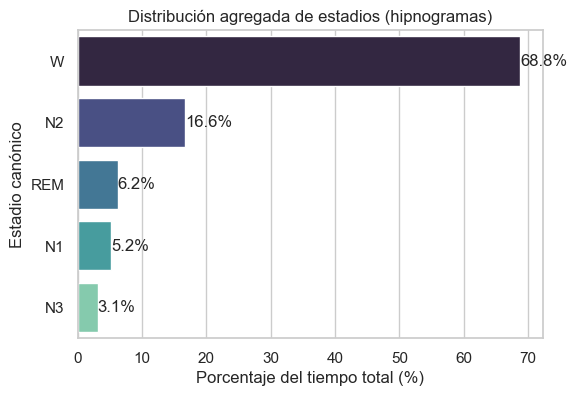

In [15]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=stage_totals.sort_values("percent", ascending=False),
    x="percent",
    y="stage",
    palette="mako",
)
plt.xlabel("Porcentaje del tiempo total (%)")
plt.ylabel("Estadio canónico")
plt.title("Distribución agregada de estadios (hipnogramas)")
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.1f%%")
plt.show()

In [16]:
subject_stage_share = stages_all.copy()
subject_stage_share["total_subject"] = subject_stage_share.groupby("subject_id")[
    "duration_sec"
].transform("sum")
subject_stage_share["percent"] = (
    100 * subject_stage_share["duration_sec"] / subject_stage_share["total_subject"]
)
subject_stage_share.head()

,stage,duration_sec,subject_id,total_subject,percent
0,N1,4350.0,SC4411E,81840.0,5.315249
1,N2,15060.0,SC4411E,81840.0,18.401760
2,N3,1380.0,SC4411E,81840.0,1.686217
3,REM,6120.0,SC4411E,81840.0,7.478006
4,W,54930.0,SC4411E,81840.0,67.118768


/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/2309644213.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subject_stage_share, x="stage", y="percent", palette="Set2")


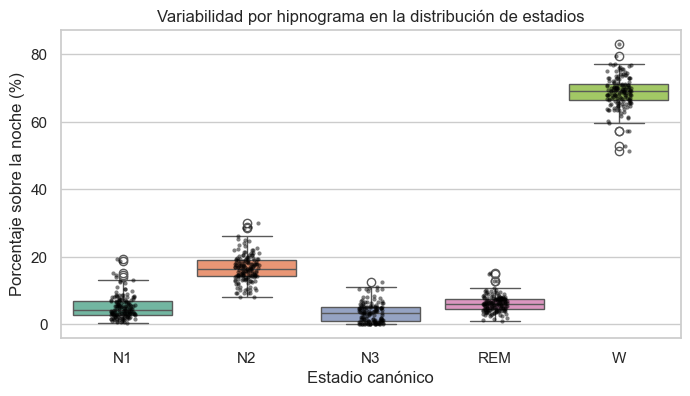

In [17]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=subject_stage_share, x="stage", y="percent", palette="Set2")
sns.stripplot(
    data=subject_stage_share, x="stage", y="percent", color="black", alpha=0.5, size=3
)
plt.ylabel("Porcentaje sobre la noche (%)")
plt.xlabel("Estadio canónico")
plt.title("Variabilidad por hipnograma en la distribución de estadios")
plt.show()

## 3. Ejemplos de señales por estadio
Vamos a elegir algunos sujetos y recortar segmentos representativos de diferentes estadios (vigilia, N1, N2, N3 y REM).

In [18]:
DEFAULT_CHANNELS = ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"]


def get_session_paths(subject_id: str) -> tuple[Path, Path]:
    match = manifest[
        (manifest["subject_id"] == subject_id) & (manifest["status"] == "ok")
    ]
    if match.empty:
        raise ValueError(f"No hay sesión 'ok' para el sujeto {subject_id}")
    row = match.iloc[0]
    psg_path = Path(row.psg_path)
    hypnogram_path = Path(row.hypnogram_path)
    if not psg_path.is_absolute():
        psg_path = PROJECT_ROOT / psg_path
    if not hypnogram_path.is_absolute():
        hypnogram_path = PROJECT_ROOT / hypnogram_path
    return psg_path, hypnogram_path


def merge_stage_regions(hypnogram_path: Path | str, stage: str):
    hypnogram_path = Path(hypnogram_path)
    annotations = mne.read_annotations(hypnogram_path)
    regions = []
    current_start = None
    current_end = None
    for onset, duration, desc in zip(
        annotations.onset, annotations.duration, annotations.description
    ):
        canonical = STAGE_CANONICAL.get(desc)
        if canonical == stage:
            if current_start is None:
                current_start = onset
                current_end = onset + duration
            else:
                current_end = onset + duration
        else:
            if current_start is not None:
                regions.append((current_start, current_end))
                current_start = None
                current_end = None
    if current_start is not None:
        regions.append((current_start, current_end))
    return regions


def find_stage_window(hypnogram_path: Path | str, stage: str, duration: float = 120.0):
    regions = merge_stage_regions(hypnogram_path, stage)
    if not regions:
        return None
    regions.sort(key=lambda r: r[1] - r[0], reverse=True)
    longest_start, longest_end = regions[0]
    window_duration = longest_end - longest_start
    if window_duration <= 0:
        return None
    if window_duration >= duration:
        return longest_start, longest_start + duration
    return longest_start, longest_end


def extract_segment(
    psg_path: Path | str,
    start: float,
    end: float,
    picks=None,
    resample: float | None = 100.0,
):
    psg_path = Path(psg_path)
    raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
    available = raw.ch_names
    if picks is None:
        picks = [ch for ch in DEFAULT_CHANNELS if ch in available] or available
    raw.pick_channels(picks)
    if resample:
        raw.resample(resample)
    segment = raw.copy().crop(tmin=start, tmax=end)
    data = segment.get_data()
    times = segment.times
    return times, data, segment.ch_names


def plot_segment(
    subject_id: str, stage: str, duration: float = 120.0, resample: float | None = 100.0
):
    psg_path, hypnogram_path = get_session_paths(subject_id)
    if not hypnogram_path.exists():
        raise FileNotFoundError(
            f"No hay hipnograma para {subject_id} ({hypnogram_path})"
        )
    if not psg_path.exists():
        raise FileNotFoundError(f"No hay PSG para {subject_id} ({psg_path})")
    window = find_stage_window(hypnogram_path, stage, duration)
    if window is None:
        raise RuntimeError(
            f"No se encontró una ventana de {duration}s en estadio {stage} para {subject_id}"
        )
    start, end = window
    times, data, channels = extract_segment(psg_path, start, end, resample=resample)
    fig, axes = plt.subplots(
        len(channels), 1, figsize=(14, 2.0 * len(channels)), sharex=True
    )
    if len(channels) == 1:
        axes = [axes]
    for idx, ax in enumerate(axes):
        ax.plot(times, data[idx])
        ax.set_ylabel(channels[idx])
        ax.grid(True, linestyle="--", alpha=0.3)
    axes[-1].set_xlabel("Tiempo (s)")
    fig.suptitle(
        f"{subject_id} | Estadio {stage} | {duration:.0f}s desde t={start:.1f}s"
    )
    fig.tight_layout(rect=(0, 0, 1, 0.96))
    return fig

In [19]:
stage_targets = ["W", "N1", "N2", "N3", "REM"]
subjects_available = subject_stage_share["subject_id"].unique().tolist()
if not subjects_available:
    raise RuntimeError("No hay sujetos con hipnograma disponible para los ejemplos.")

rng = np.random.default_rng(RANDOM_SEED)
example_plan: list[tuple[str, str]] = []
for idx, stage in enumerate(stage_targets):
    candidates = subject_stage_share[subject_stage_share["stage"] == stage]
    if candidates.empty:
        print(f"No se encontraron sujetos con estadio {stage}.")
        continue
    weights = candidates["percent"].to_numpy(dtype=float)
    if np.isclose(weights.sum(), 0.0):
        selection = candidates.sample(n=1, random_state=RANDOM_SEED + idx)
        subject_id = selection.iloc[0]["subject_id"]
    else:
        weights = weights / weights.sum()
        selection_idx = rng.choice(len(candidates), p=weights)
        subject_id = candidates.iloc[selection_idx]["subject_id"]
    example_plan.append((subject_id, stage))

if not example_plan:
    raise RuntimeError(
        "No fue posible planificar ejemplos de segmentos para los estadios solicitados."
    )

example_plan

[('SC4352F', 'W'),
 ('SC4512E', 'N1'),
 ('SC4731E', 'N2'),
 ('SC4412E', 'N3'),
 ('SC4562F', 'REM')]

/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_9274/3048042758.py:68: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


[('SC4352F', 'W', <Figure size 1400x800 with 4 Axes>),
 ('SC4512E', 'N1', <Figure size 1400x800 with 4 Axes>),
 ('SC4731E', 'N2', <Figure size 1400x800 with 4 Axes>),
 ('SC4412E', 'N3', <Figure size 1400x800 with 4 Axes>),
 ('SC4562F', 'REM', <Figure size 1400x800 with 4 Axes>)]

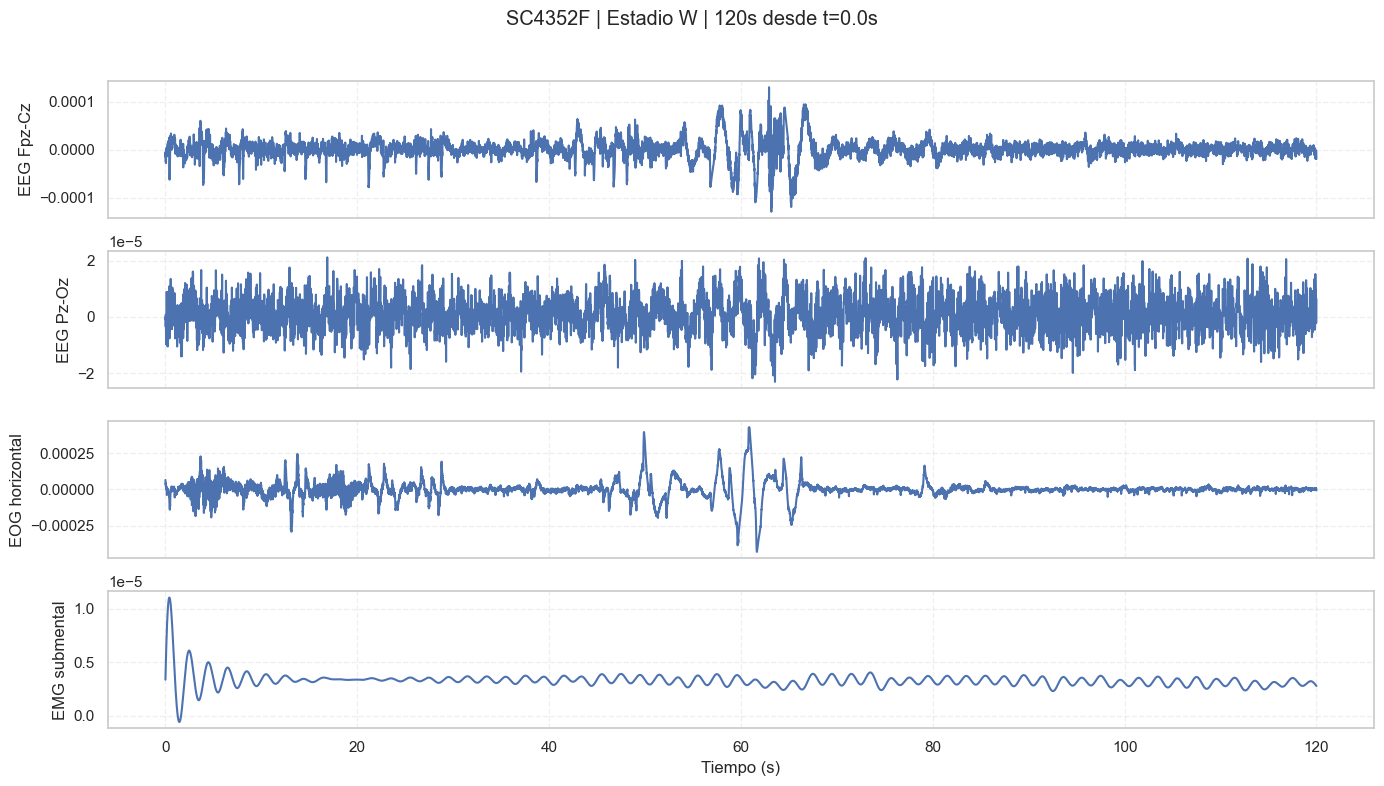

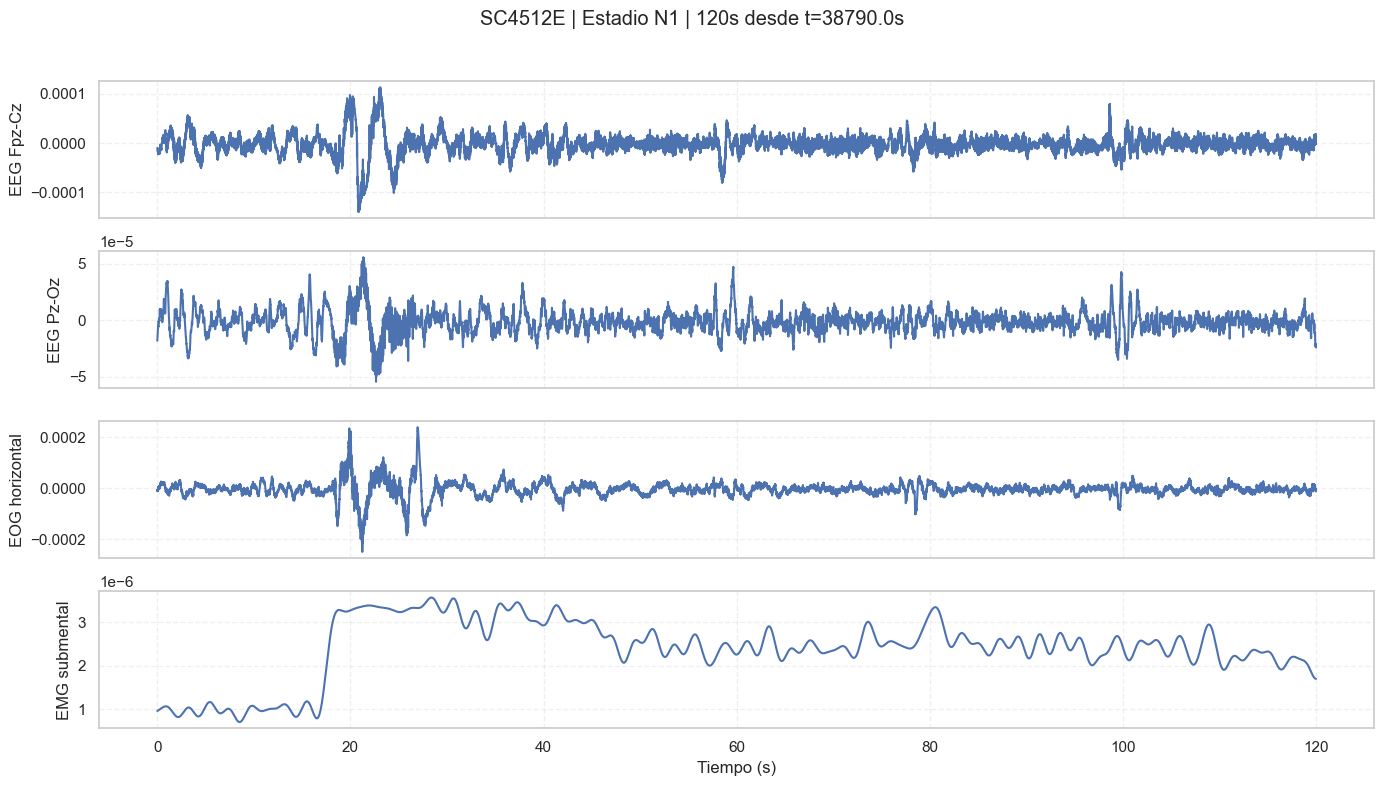

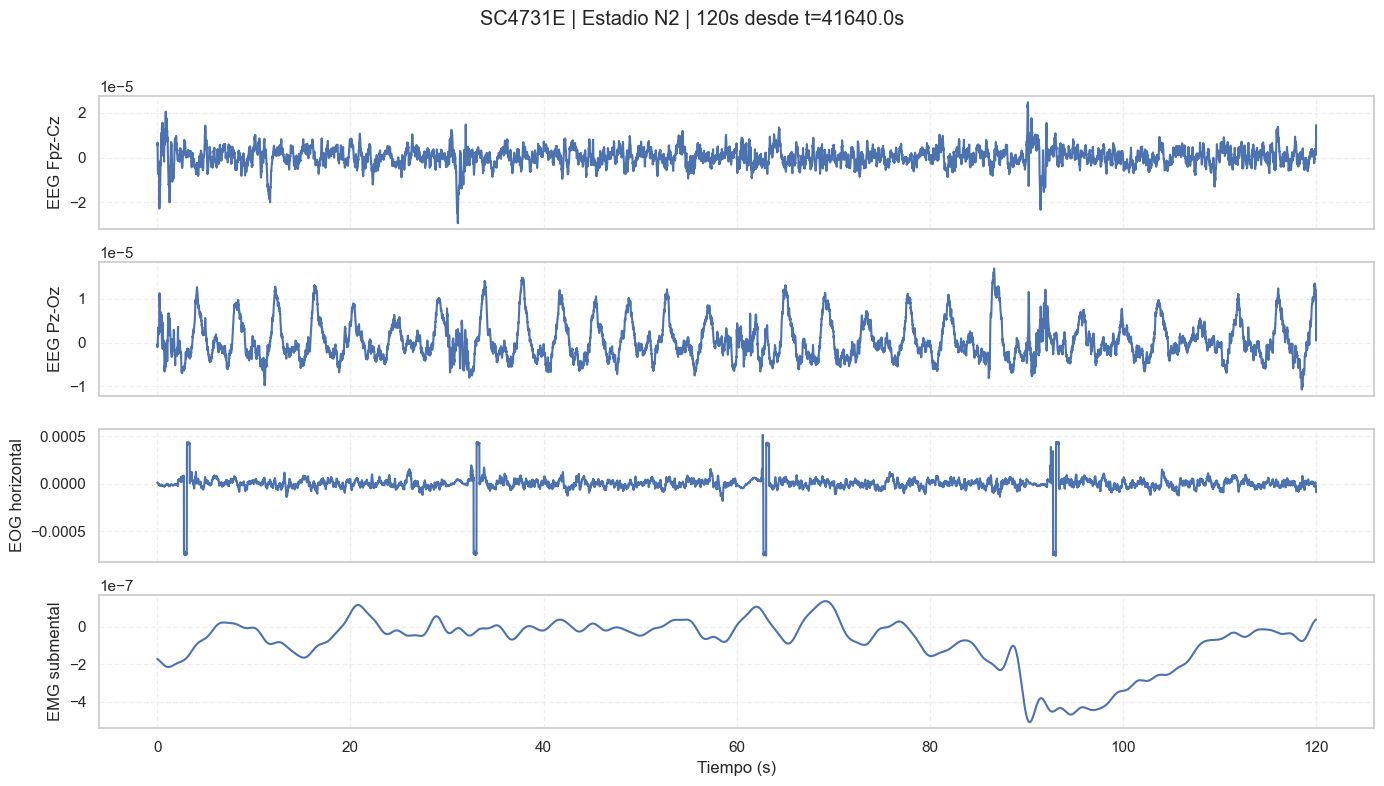

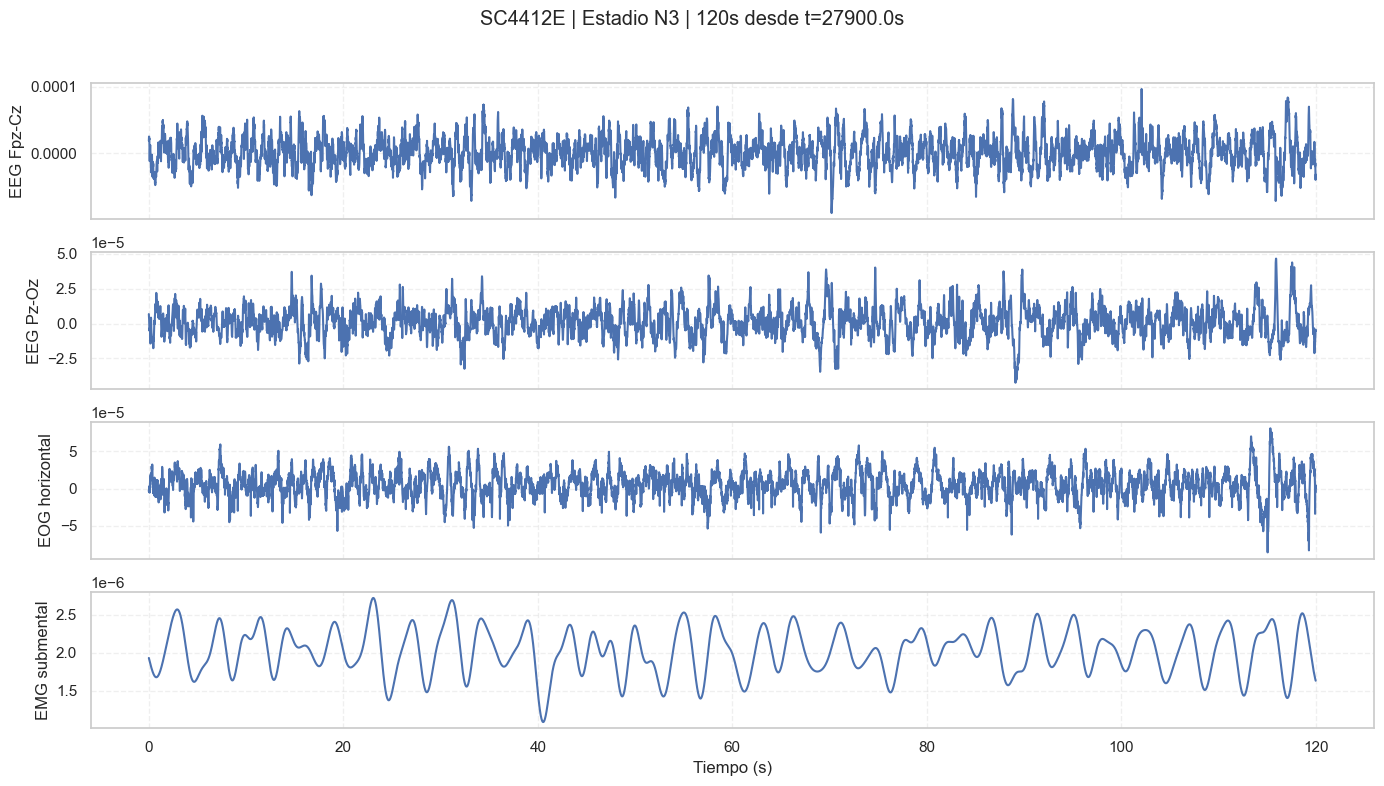

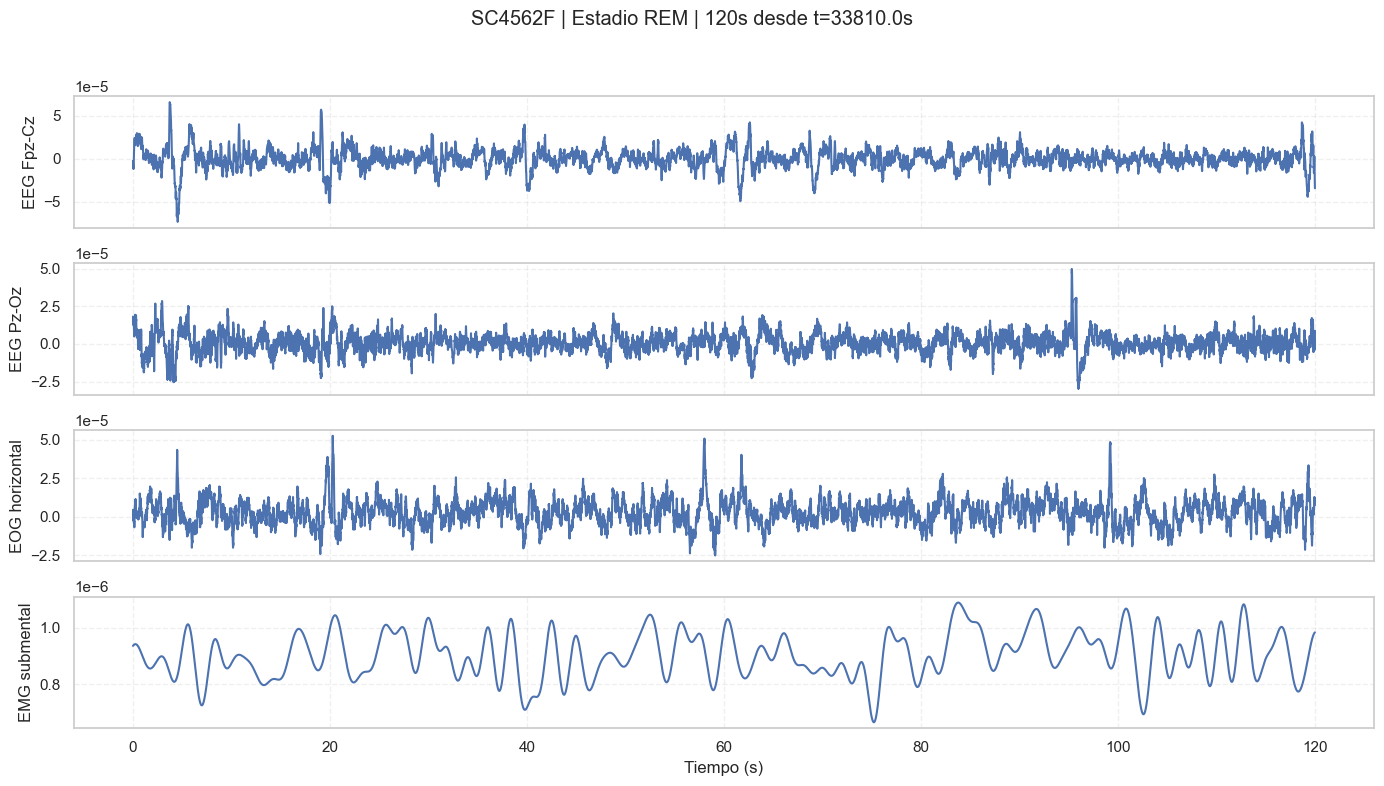

In [20]:
figures = []
for subject_id, stage in example_plan:
    try:
        fig = plot_segment(subject_id, stage, duration=120.0)
        figures.append((subject_id, stage, fig))
    except Exception as exc:
        print(f"No se pudo generar segmento para {subject_id} - {stage}: {exc}")
figures

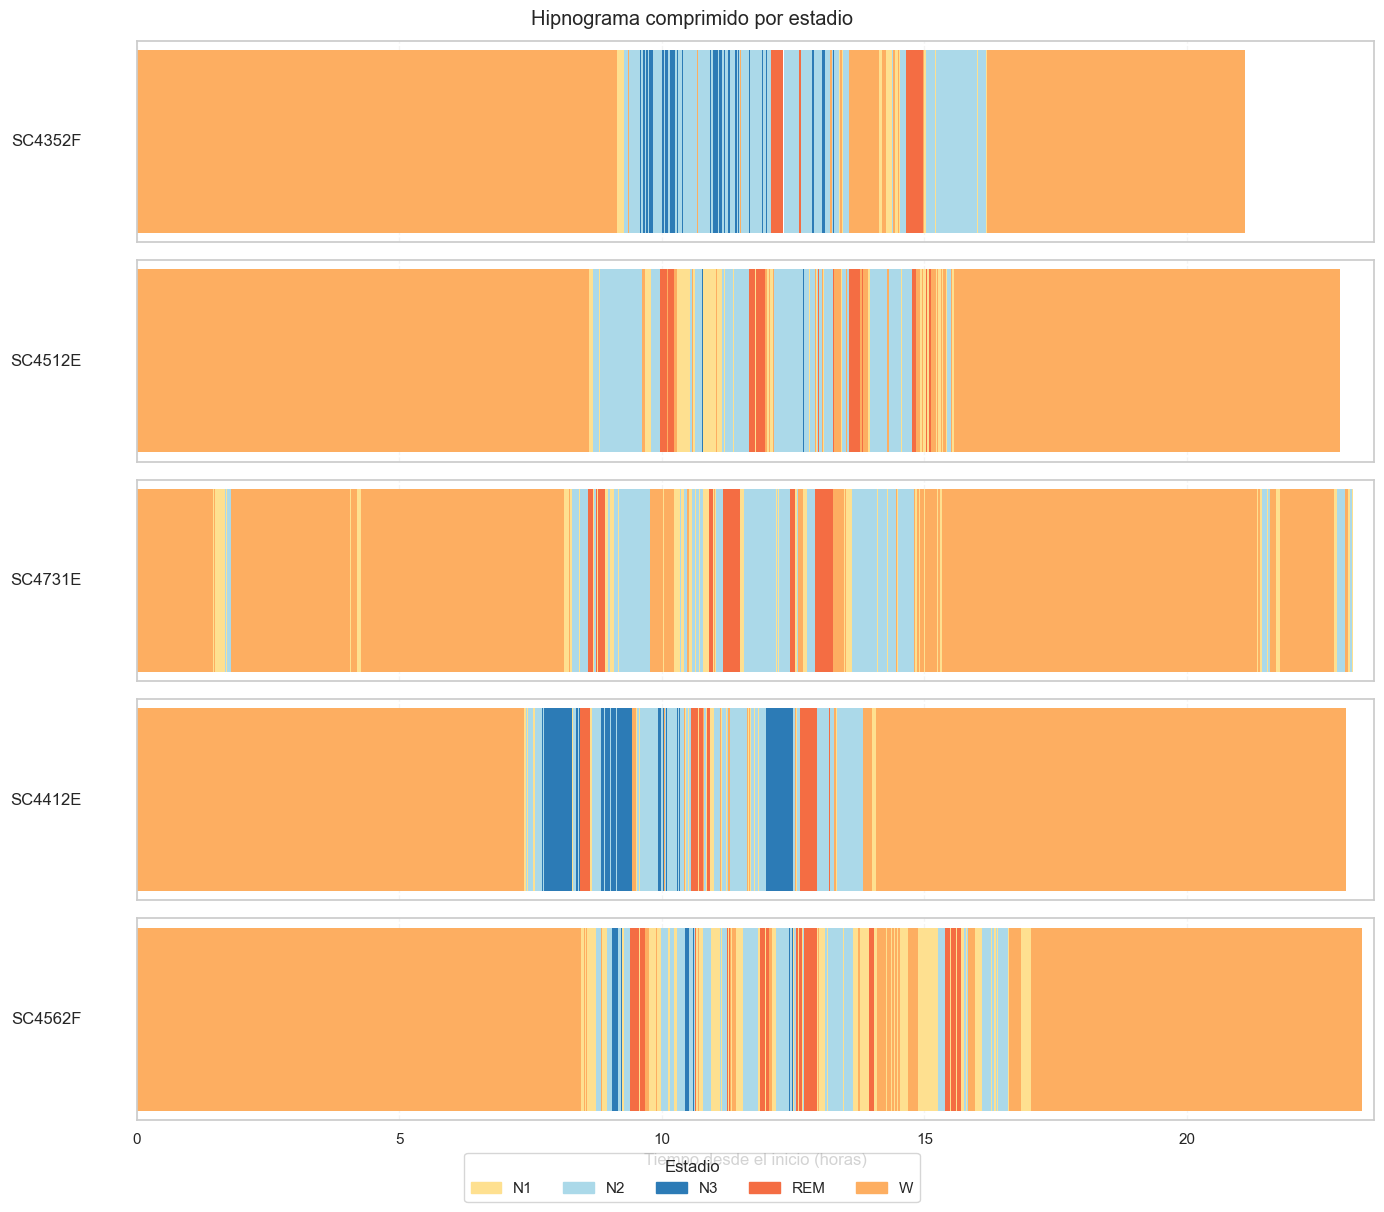

In [21]:
STAGE_COLORS = {
    "W": "#fdae61",
    "N1": "#fee090",
    "N2": "#abd9e9",
    "N3": "#2c7bb6",
    "REM": "#f46d43",
}


def build_stage_timeline(hypnogram_path: Path | str) -> pd.DataFrame:
    hypnogram_path = Path(hypnogram_path)
    annotations = mne.read_annotations(hypnogram_path)
    rows: list[dict[str, float | str]] = []
    current_stage = None
    current_start = None
    current_end = None
    for onset, duration, desc in zip(
        annotations.onset, annotations.duration, annotations.description
    ):
        stage = STAGE_CANONICAL.get(desc)
        if stage is None:
            continue
        start = float(onset)
        end = float(onset + duration)
        if current_stage == stage:
            current_end = end
        else:
            if current_stage is not None and current_start is not None:
                rows.append(
                    {
                        "stage": current_stage,
                        "start_sec": current_start,
                        "end_sec": current_end,
                    }
                )
            current_stage = stage
            current_start = start
            current_end = end
    if current_stage is not None and current_start is not None:
        rows.append(
            {
                "stage": current_stage,
                "start_sec": current_start,
                "end_sec": current_end,
            }
        )
    return pd.DataFrame(rows)


def plot_stage_timelines(
    subject_ids: list[str] | None = None, duration_unit: str = "hours"
):
    if subject_ids is None:
        available = list(subject_stage_share["subject_id"].unique())
        if not available:
            raise RuntimeError(
                "No hay sujetos con hipnograma disponible para graficar el cassette completo."
            )
        subject_ids = available[:3]
    if not subject_ids:
        raise ValueError("Debés especificar al menos un sujeto para graficar.")

    unit_factor = (
        3600 if duration_unit == "hours" else 60 if duration_unit == "minutes" else 1
    )
    unit_label = {"hours": "horas", "minutes": "minutos", "seconds": "segundos"}.get(
        duration_unit, "unidades"
    )

    fig, axes = plt.subplots(
        len(subject_ids), 1, figsize=(14, 2 + 2 * len(subject_ids)), sharex=True
    )
    if len(subject_ids) == 1:
        axes = [axes]

    legends_stages = set()
    for ax, subject_id in zip(axes, subject_ids):
        _, hypnogram_path = get_session_paths(subject_id)
        if not hypnogram_path.exists():
            ax.text(0.5, 0.5, f"Sin hipnograma: {subject_id}", ha="center", va="center")
            ax.axis("off")
            continue
        timeline = build_stage_timeline(hypnogram_path)
        if timeline.empty:
            ax.text(
                0.5, 0.5, f"Hipnograma vacío: {subject_id}", ha="center", va="center"
            )
            ax.axis("off")
            continue
        for _, row in timeline.iterrows():
            width = (row["end_sec"] - row["start_sec"]) / unit_factor
            left = row["start_sec"] / unit_factor
            stage = row["stage"]
            color = STAGE_COLORS.get(stage, "0.7")
            ax.barh(
                y=0,
                width=width,
                left=left,
                height=0.6,
                color=color,
                edgecolor="none",
            )
            legends_stages.add(stage)
        max_time = timeline["end_sec"].max() / unit_factor
        ax.set_xlim(0, max_time * 1.01)
        ax.set_yticks([])
        ax.set_ylabel(subject_id, rotation=0, labelpad=40, va="center", ha="right")
        ax.grid(axis="x", linestyle="--", alpha=0.2)
    axes[-1].set_xlabel(f"Tiempo desde el inicio ({unit_label})")
    fig.suptitle("Hipnograma comprimido por estadio", y=0.98)

    handles = [
        plt.Rectangle((0, 0), 1, 1, color=STAGE_COLORS.get(stage, "0.7"))
        for stage in sorted(legends_stages)
    ]
    fig.legend(
        handles,
        sorted(legends_stages),
        title="Estadio",
        loc="lower center",
        bbox_to_anchor=(0.5, -0.02),
        ncol=min(len(legends_stages), 5),
    )
    plt.tight_layout()
    plt.close(fig)
    return fig


timeline_subjects = list(dict.fromkeys(subject_id for subject_id, _ in example_plan))
plot_stage_timelines(timeline_subjects)